# **NT522.O21.ANTT.2**

# **21520155 - Nguyễn Triệu Thiên Bảo**
# **21521195 - Trần Lê Minh Ngọc**

# **Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình LSTM**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình LSTM để phát hiện điểm bất thường trên tập dữ liệu lưu lượng mạng KDD99.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-35-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-35-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-35-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [ ]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [ ]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
df = df.replace({True: 1, False: 0})

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/3
271/271 [==============================] - 7s 20ms/step - loss: 0.1434 - accuracy: 0.8230 - val_loss: 0.0165 - val_accuracy: 0.9810
Epoch 2/3
271/271 [==============================] - 5s 17ms/step - loss: 0.0129 - accuracy: 0.9861 - val_loss: 0.0097 - val_accuracy: 0.9894
Epoch 3/3
271/271 [==============================] - 4s 16ms/step - loss: 0.0109 - accuracy: 0.9885 - val_loss: 0.0106 - val_accuracy: 0.9888


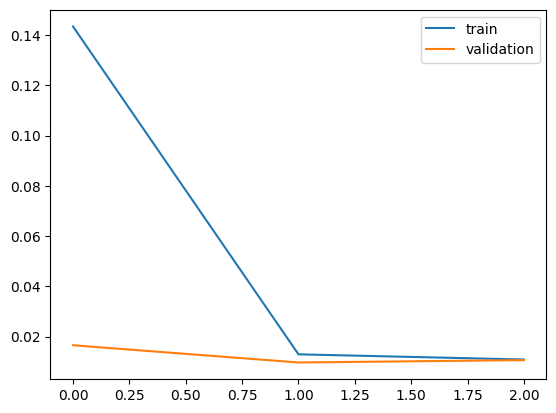

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 [==============================] - 2s 7ms/step - loss: 0.0109 - accuracy: 0.9885


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

x_test = x_test.astype('float32')
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.numpy(), axis=1)

4632/4632 [==============================] - 15s 3ms/step


In [ ]:
#confusion matrix
confusionmatrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(confusionmatrix)

Confusion Matrix:
[[ 28391    724]
 [  1002 118090]]


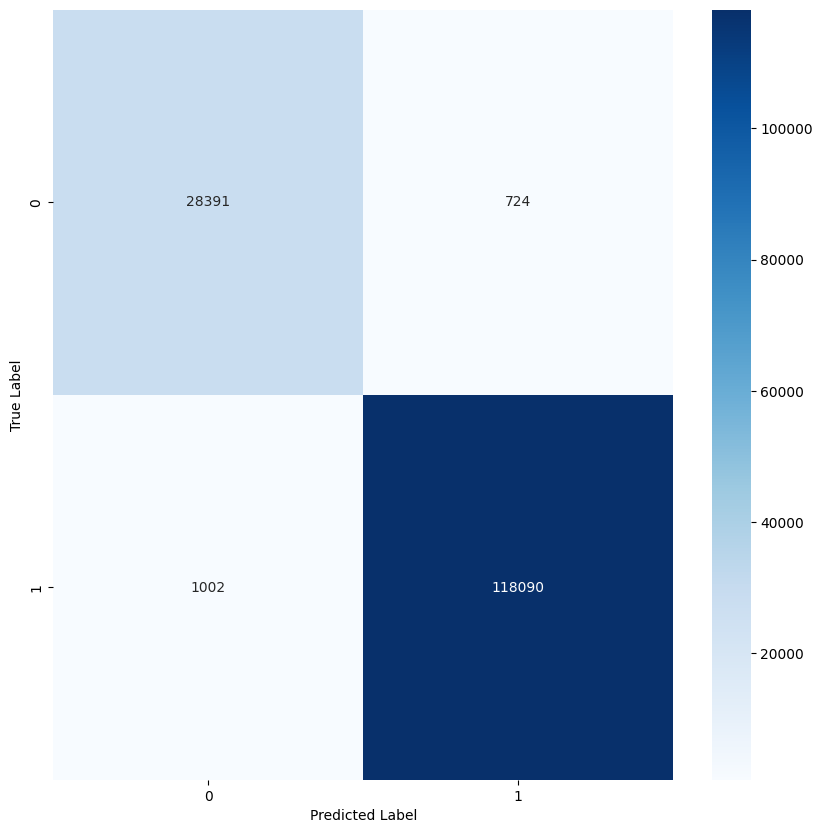

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Calculate the precision, recall, and F1-score
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

4632/4632 [==============================] - 15s 3ms/step
Precision: 0.9939064420017844
Recall: 0.9915863366137104
F1-score: 0.9927450337528267


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





# **Yêu cầu 1: Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**

## **1.   Đọc tập dữ liệu KDD99**




In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-58-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-58-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-58-ede0120ec756>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [ ]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [ ]:
labels = df["outcome"].unique()
for i, label in enumerate(labels):
    if label == "normal.":
        df.loc[df["outcome"] == label, "outcome"] = 0
    else:
        df.loc[df["outcome"] == label, "outcome"] = i+1

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
df = df.replace({True: 1, False: 0})

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/3
271/271 [==============================] - 7s 18ms/step - loss: 0.2320 - accuracy: 0.9401 - val_loss: 0.2153 - val_accuracy: 0.9984
Epoch 2/3
271/271 [==============================] - 5s 17ms/step - loss: 0.2156 - accuracy: 0.8936 - val_loss: 0.2150 - val_accuracy: 0.9982
Epoch 3/3
271/271 [==============================] - 5s 17ms/step - loss: 0.2152 - accuracy: 0.9024 - val_loss: 0.2144 - val_accuracy: 0.8256


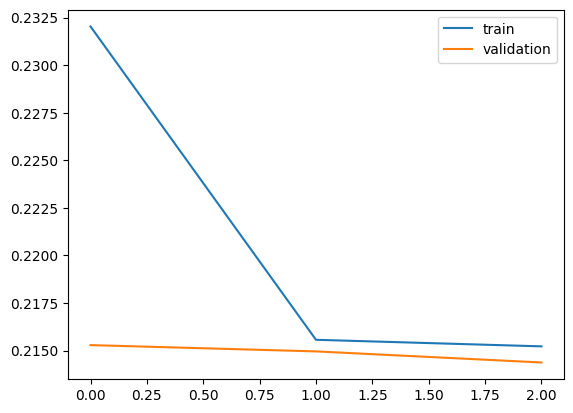

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 [==============================] - 2s 7ms/step - loss: 0.2144 - accuracy: 0.8240


# **Yêu cầu 2:  Sinh viên chạy lại tập dữ liệu CIC IDS 2018 trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**

# **Cài đặt các công cụ cần thiết**

In [ ]:
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscli-exe-linux-x86_64.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.7M  100 57.7M    0     0   145M      0 --:--:-- --:--:-- --:--:--  145M


In [ ]:
!unzip awscli-exe-linux-x86_64.zip

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/awscli/examples/apigatewayv2/create-deployment.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/update-domain-name.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/untag-resource.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/get-authorizer.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/update-stage.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/delete-route.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/update-deployment.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/get-deployments.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/create-route.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/delete-integration.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/get-authorizers.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/create-authorizer.rst  
  inflating: aws/dist/awscli/examples/apigatewayv2/import-api.rst  
  in

In [ ]:
!sudo ./aws/install

You can now run: /usr/local/bin/aws --version


In [ ]:
!/usr/local/bin/aws --version

aws-cli/2.15.47 Python/3.11.8 Linux/6.1.58+ exe/x86_64.ubuntu.22 prompt/off


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/"

                           PRE Original Network Traffic and Log data/
                           PRE Processed Traffic Data for ML Algorithms/


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Original Network Traffic and Log data/"

                           PRE Friday-02-03-2018/
                           PRE Friday-16-02-2018/
                           PRE Friday-23-02-2018/
                           PRE Thursday-01-03-2018/
                           PRE Thursday-15-02-2018/
                           PRE Thursday-22-02-2018/
                           PRE Tuesday-20-02-2018/
                           PRE Wednesday-14-02-2018/
                           PRE Wednesday-21-02-2018/
                           PRE Wednesday-28-02-2018/
2018-10-10 11:52:09          0 


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"

2018-10-11 16:02:25          0 
2018-10-11 16:02:49  352368373 Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:10  333723605 Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:33  382840456 Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:59 4054925350 Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:38  107842858 Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:48  375945899 Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:20  382636202 Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:44  358223333 Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:12  328893673 Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:33  209249758 Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


In [ ]:
!aws s3 cp --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv" "/content/drive/MyDrive/NT522.O21.ANTT_Lab5/"

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/NT522.O21.ANTT_Lab5/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv


# **Binary Classification**

## **1. Đọc dữ liệu**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NT522.O21.ANTT_Lab5/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv', nrows=200000)
print("Read {} rows.".format(len(df)))
df

Read 200000 rows.


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734.0,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,80,6,16/02/2018 01:45:49,4142,2,0,0,0,0,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-Hulk
199996,40012,6,16/02/2018 01:45:44,5393905,5,3,935,345,935,0,...,32,0.0,0.0,0,0,5311166.0,0.000000,5311166,5311166,Benign
199997,39978,6,16/02/2018 01:45:44,5414995,5,3,935,358,935,0,...,32,0.0,0.0,0,0,5326311.0,0.000000,5326311,5326311,Benign
199998,40022,6,16/02/2018 01:45:44,5156071,5,3,935,351,935,0,...,32,0.0,0.0,0,0,5073832.0,0.000000,5073832,5073832,Benign


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(200000, 80)

In [ ]:
df.dtypes

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object

In [ ]:
df.groupby('Label')['Label'].count()

Label
Benign                      41216
DoS attacks-Hulk            67350
DoS attacks-SlowHTTPTest    91434
Name: Label, dtype: int64

In [ ]:
# Loại bỏ các cột chỉ có 1 giá trị để tiết kiệm thời gian tính toán
def remove_single_value_columns(dataframe):
    col_names = dataframe.columns
    unique_values = [len(dataframe[col].unique()) for col in col_names]

    col_unique_df = pd.DataFrame({'ColName': col_names, 'UniqueValues': unique_values})
    single_val_cols_df = col_unique_df[col_unique_df['UniqueValues'] == 1]
    return col_unique_df, single_val_cols_df


def sort_data_by_time(dataframe, time_col="Timestamp"):
    sorted_data = dataframe.sort_values(by=[time_col], ascending=True)
    return sorted_data

col_unique_df, single_val_cols_df = remove_single_value_columns(df)
df = df.drop(columns=single_val_cols_df['ColName'].values)

# Sắp xếp dữ liệu theo thời gian
df = sort_data_by_time(df)

df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,0,0,16/02/2018 01:00:32,112640723,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,101.116270,56300000,56300000,Benign
91658,22,6,16/02/2018 01:01:42,2146470,14,12,1335,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91661,0,0,16/02/2018 01:03:21,112640737,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,17.677670,56300000,56300000,Benign
91689,67,17,16/02/2018 01:03:50,721,1,1,300,329,300,300,...,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91663,0,0,16/02/2018 01:06:10,112640647,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,58.689863,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91653,0,0,16/02/2018 12:52:05,112640636,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
91654,0,0,16/02/2018 12:54:54,112640695,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,26.162951,56300000,56300000,Benign
91657,0,0,16/02/2018 12:57:43,112640664,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,28.284271,56300000,56300000,Benign
91655,22,6,16/02/2018 12:58:13,10162102,9,7,1063,1297,744,0,...,32,989739.0,0.0,989739,989739,9172344.0,0.000000,9172344,9172344,Benign


In [ ]:
# Xóa cột timestamp
# Timestamp không đóng góp vào việc training model vì vậy xóa nó đi để giảm kích thước dữ liệu cũng như tránh trường hợp overfitting
df.drop('Timestamp', axis=1, inplace=True)
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,0,0,112640723,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,101.116270,56300000,56300000,Benign
91658,22,6,2146470,14,12,1335,2273,744,0,95.357143,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91661,0,0,112640737,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,17.677670,56300000,56300000,Benign
91689,67,17,721,1,1,300,329,300,300,300.000000,...,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91663,0,0,112640647,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,58.689863,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91653,0,0,112640636,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
91654,0,0,112640695,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,26.162951,56300000,56300000,Benign
91657,0,0,112640664,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,28.284271,56300000,56300000,Benign
91655,22,6,10162102,9,7,1063,1297,744,0,118.111111,...,32,989739.0,0.0,989739,989739,9172344.0,0.000000,9172344,9172344,Benign


## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =[ ]

for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,-0.500746,-36.506422,32.154667,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.002866,21.975696,22.004887,Benign
91658,-0.499600,0.016953,0.274845,7.166526,4.317151,2.962521,0.600508,1.407392,-0.007926,0.623005,...,-0.889378,-0.008343,-0.004305,-0.006545,-0.010212,-0.432624,-0.004488,-0.432351,-0.432761,Benign
91661,-0.500746,-36.506422,32.154671,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.004204,21.975696,22.004887,Benign
91689,-0.497257,66.976473,-0.344246,-0.761037,-0.172995,0.219894,0.048766,0.223401,133.733807,3.251916,...,-6.762220,-0.008343,-0.004305,-0.006545,-0.010212,-0.432624,-0.004488,-0.432351,-0.432761,Benign
91663,-0.500746,-36.506422,32.154645,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.003546,21.975696,22.004887,Benign


In [ ]:
df.loc[df["Label"] != "Benign.", "Label"] = 1
df.loc[df["Label"] == "Benign.", "Label"] = 0

In [ ]:
y = df['Label']
df.drop('Label',axis=1,inplace=True)

In [ ]:
df = df.replace({True: 1, False: 0})

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {X_train.shape, Y_train.shape}")
print(f"Normal test count: {X_test.shape, Y_test.shape}")

Normal train count: ((140000, 67), (140000,))
Normal test count: ((60000, 67), (60000,))


In [ ]:
# Convert Y_train and Y_test to one-hot encoding
Y_train = tf.one_hot(Y_train.values, 2)
Y_test = tf.one_hot(Y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                2176      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2242 (8.76 KB)
Trainable params: 2242 (8.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/3
110/110 [==============================] - 1s 5ms/step - loss: 0.0499 - accuracy: 0.9444 - val_loss: 7.8505e-04 - val_accuracy: 0.9997
Epoch 2/3
110/110 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 0.9977 - val_loss: 3.3052e-04 - val_accuracy: 0.9997
Epoch 3/3
110/110 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 1.5410e-04 - val_accuracy: 0.9999


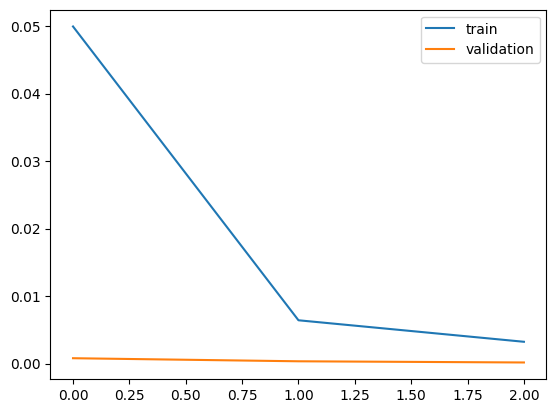

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(X_train, Y_train, batch_size=1024)

137/137 [==============================] - 1s 6ms/step - loss: 1.0434e-04 - accuracy: 0.9999


# **Multiclass Classification**

## **1. Đọc dữ liệu**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NT522.O21.ANTT_Lab5/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv', nrows=200000)
print("Read {} rows.".format(len(df)))
df

Read 200000 rows.


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734.0,0.0,2624734,2624734,9058214.0,0.000000,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,80,6,16/02/2018 01:45:49,4142,2,0,0,0,0,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-Hulk
199996,40012,6,16/02/2018 01:45:44,5393905,5,3,935,345,935,0,...,32,0.0,0.0,0,0,5311166.0,0.000000,5311166,5311166,Benign
199997,39978,6,16/02/2018 01:45:44,5414995,5,3,935,358,935,0,...,32,0.0,0.0,0,0,5326311.0,0.000000,5326311,5326311,Benign
199998,40022,6,16/02/2018 01:45:44,5156071,5,3,935,351,935,0,...,32,0.0,0.0,0,0,5073832.0,0.000000,5073832,5073832,Benign


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(200000, 80)

In [ ]:
df.dtypes

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object

In [ ]:
df.groupby('Label')['Label'].count()

Label
Benign                      41216
DoS attacks-Hulk            67350
DoS attacks-SlowHTTPTest    91434
Name: Label, dtype: int64

In [ ]:
# Loại bỏ các cột chỉ có 1 giá trị để tiết kiệm thời gian tính toán
def remove_single_value_columns(dataframe):
    col_names = dataframe.columns
    unique_values = [len(dataframe[col].unique()) for col in col_names]

    col_unique_df = pd.DataFrame({'ColName': col_names, 'UniqueValues': unique_values})
    single_val_cols_df = col_unique_df[col_unique_df['UniqueValues'] == 1]
    return col_unique_df, single_val_cols_df


def sort_data_by_time(dataframe, time_col="Timestamp"):
    sorted_data = dataframe.sort_values(by=[time_col], ascending=True)
    return sorted_data

col_unique_df, single_val_cols_df = remove_single_value_columns(df)
df = df.drop(columns=single_val_cols_df['ColName'].values)

# Sắp xếp dữ liệu theo thời gian
df = sort_data_by_time(df)

df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,0,0,16/02/2018 01:00:32,112640723,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,101.116270,56300000,56300000,Benign
91658,22,6,16/02/2018 01:01:42,2146470,14,12,1335,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91661,0,0,16/02/2018 01:03:21,112640737,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,17.677670,56300000,56300000,Benign
91689,67,17,16/02/2018 01:03:50,721,1,1,300,329,300,300,...,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91663,0,0,16/02/2018 01:06:10,112640647,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,58.689863,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91653,0,0,16/02/2018 12:52:05,112640636,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
91654,0,0,16/02/2018 12:54:54,112640695,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,26.162951,56300000,56300000,Benign
91657,0,0,16/02/2018 12:57:43,112640664,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56300000.0,28.284271,56300000,56300000,Benign
91655,22,6,16/02/2018 12:58:13,10162102,9,7,1063,1297,744,0,...,32,989739.0,0.0,989739,989739,9172344.0,0.000000,9172344,9172344,Benign


In [ ]:
# Xóa cột timestamp
# Timestamp không đóng góp vào việc training model vì vậy xóa nó đi để giảm kích thước dữ liệu cũng như tránh trường hợp overfitting
df.drop('Timestamp', axis=1, inplace=True)
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,0,0,112640723,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,101.116270,56300000,56300000,Benign
91658,22,6,2146470,14,12,1335,2273,744,0,95.357143,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91661,0,0,112640737,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,17.677670,56300000,56300000,Benign
91689,67,17,721,1,1,300,329,300,300,300.000000,...,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
91663,0,0,112640647,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,58.689863,56300000,56300000,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91653,0,0,112640636,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
91654,0,0,112640695,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,26.162951,56300000,56300000,Benign
91657,0,0,112640664,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56300000.0,28.284271,56300000,56300000,Benign
91655,22,6,10162102,9,7,1063,1297,744,0,118.111111,...,32,989739.0,0.0,989739,989739,9172344.0,0.000000,9172344,9172344,Benign


## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =[ ]

for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,-0.500746,-36.506422,32.154667,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.002866,21.975696,22.004887,Benign
91658,-0.499600,0.016953,0.274845,7.166526,4.317151,2.962521,0.600508,1.407392,-0.007926,0.623005,...,-0.889378,-0.008343,-0.004305,-0.006545,-0.010212,-0.432624,-0.004488,-0.432351,-0.432761,Benign
91661,-0.500746,-36.506422,32.154671,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.004204,21.975696,22.004887,Benign
91689,-0.497257,66.976473,-0.344246,-0.761037,-0.172995,0.219894,0.048766,0.223401,133.733807,3.251916,...,-6.762220,-0.008343,-0.004305,-0.006545,-0.010212,-0.432624,-0.004488,-0.432351,-0.432761,Benign
91663,-0.500746,-36.506422,32.154645,0.458588,-0.581190,-0.575070,-0.044611,-0.576593,-0.007926,-0.601985,...,-8.719834,-0.008343,-0.004305,-0.006545,-0.010212,21.993811,-0.003546,21.975696,22.004887,Benign


In [ ]:
labels = df["Label"].unique()
for i, label in enumerate(labels):
    if label == "Benign":
        df.loc[df["Label"] == label, "Label"] = 0
    else:
        df.loc[df["Label"] == label, "Label"] = i+1

In [ ]:
y = df['Label']
df.drop('Label',axis=1,inplace=True)

In [ ]:
df = df.replace({True: 1, False: 0})

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {X_train.shape, Y_train.shape}")
print(f"Normal test count: {X_test.shape, Y_test.shape}")

Normal train count: ((140000, 67), (140000,))
Normal test count: ((60000, 67), (60000,))


In [ ]:
# Convert Y_train and Y_test to one-hot encoding
Y_train = tf.one_hot(Y_train.values, 2)
Y_test = tf.one_hot(Y_test.values, 2)

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 32)                2176      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2242 (8.76 KB)
Trainable params: 2242 (8.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    X_train, Y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/3
110/110 [==============================] - 3s 8ms/step - loss: 0.2215 - accuracy: 0.5500 - val_loss: 0.2003 - val_accuracy: 0.6815
Epoch 2/3
110/110 [==============================] - 1s 6ms/step - loss: 0.2013 - accuracy: 0.6353 - val_loss: 0.1996 - val_accuracy: 0.7115
Epoch 3/3
110/110 [==============================] - 0s 4ms/step - loss: 0.2001 - accuracy: 0.6811 - val_loss: 0.1996 - val_accuracy: 0.9033


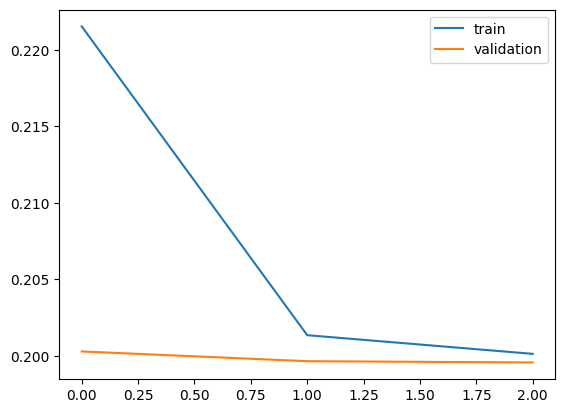

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(X_train, Y_train, batch_size=1024)

137/137 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9039
